## Exercices on Data Munging provided by The Data Incubator part of DS module by WorldQuant University

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import statsmodels.api as sm
import gzip
import simplejson as json
import glob
import os

In [ ]:
# Downloading the data from online
#################################
os.system('/usr/local/bin/wget "http://dataincubator-wqu.s3.amazonaws.com/dwdata/201606scripts_sample.csv.gz" -nc -P ./dw-data/')# had to install wget first 
os.system('/usr/local/bin/wget "http://dataincubator-wqu.s3.amazonaws.com/dwdata/201701scripts_sample.csv.gz" -nc -P ./dw-data/ ')   # Big Big file.. Megabytes
os.system('/usr/local/bin/wget "http://dataincubator-wqu.s3.amazonaws.com/dwdata/practices.csv.gz" -nc -P ./dw-data/ ')   
os.system('/usr/local/bin/wget "http://dataincubator-wqu.s3.amazonaws.com/dwdata/chem.csv.gz" -nc -P ./dw-data/')

In [2]:
#Loading Data
#############
os.chdir('/Users/bmr225/Documents/WorldQuantUniversity')

with gzip.open('./dw-data/201701scripts_sample.csv.gz', 'rb') as f:
    scripts =  pd.read_csv(f)
    scripts.head()
    
with gzip.open('./dw-data/practices.csv.gz', 'rb') as f:
    practices =  pd.read_csv(f)
col_names=[ 'code', 'name', 'addr_1', 'addr_2', 'borough', 'village', 'post_code']
practices.columns = col_names
    
with gzip.open('./dw-data/201606scripts_sample.csv.gz', 'rb') as f:
   scripts16 = pd.read_csv(f)


with gzip.open('./dw-data/chem.csv.gz', 'rb') as f:
    chem = pd.read_csv(f)

### Data Source

This data set comes from Britain's National Health Service. The `scripts` variable is a list of prescriptions issued by NHS doctors. Each prescription is represented by a variety of data fields: `'practice'`, `'bnf_code'`, `'bnf_name'`, `'quantity'`, `'items'`, `'nic'`, and `'act_cost'`. 

In [3]:
scripts.head()

,practice,bnf_code,bnf_name,items,nic,act_cost,quantity
0,N85639,0106020C0,Bisacodyl_Tab E/C 5mg,1,0.39,0.47,12
1,N85639,0106040M0,Movicol Plain_Paed Pdr Sach 6.9g,1,4.38,4.07,30
2,N85639,0301011R0,Salbutamol_Inha 100mcg (200 D) CFF,1,1.50,1.40,1
3,N85639,0304010G0,Chlorphenamine Mal_Oral Soln 2mg/5ml,1,2.62,2.44,150
4,N85639,0401020K0,Diazepam_Tab 2mg,1,0.16,0.26,6


### Task I: Summary Statistics of multiple columns

In [16]:
summary_stats = []
measures = ['items','quantity', 'nic','act_cost']
ind = list(range(7))
for measure in measures:
    descrip_stats = (measure,tuple([scripts[measure].describe()[i] for i in ind]))
    summary_stats.append(descrip_stats)

In [17]:
summary_stats
#format[('Col',(total, mean, std, q25, median, q75))]

[('items',
  (973193.0, 9.133135976111625, 29.20419828297713, 1.0, 1.0, 2.0, 6.0)),
 ('quantity',
  (973193.0, 741.3298348837282, 3665.426958468499, 0.0, 28.0, 100.0, 350.0)),
 ('nic',
  (973193.0, 73.05891517921756, 188.07025690683025, 0.0, 7.8, 22.64, 65.0)),
 ('act_cost',
  (973193.0, 67.98661326170611, 174.40170332300627, 0.04, 7.33, 21.22, 60.67))]

### Task II: Find bnf codes with the highest number of items, i.e. the most common bnf code

In [4]:
total_items_names = scripts.groupby('bnf_name')
total_items = scripts.groupby('bnf_name')['items'].sum()
total_items

bnf_name
365 Film 10cm x 12cm VP Adh Film Dress       2
365 Non Adherent 10cm x 10cm Pfa Plas Fa     3
365 Non Adherent 10cm x 20cm Pfa Plas Fa     1
365 Non Woven Island 8cm x 10cm Adh Dres     1
365 Transpt Island 5cm x 7.2cm VP Adh Fi     2
                                            ..
nSpire PiKo-1 Stnd Range Peak Flow Meter     1
nSpire Pocket Peak Low Range Peak Flow M     4
nSpire Pocket Peak Stnd Range Peak Flow      8
oraNurse_Toothpaste Orig (1450ppm)           4
palmdoc (Reagent)_Strips                    59
Name: items, Length: 13471, dtype: int64

In [5]:
v = list(total_items)
max_ind = v.index(max(v))
total_items_df = total_items.to_frame()
most_common_item = total_items_df.iloc[v.index(max(v))] 
# Most common Item
total_items_df.index.values[max_ind]

'Omeprazole_Cap E/C 20mg'

In [6]:
most_common_item

items    218583
Name: Omeprazole_Cap E/C 20mg, dtype: int64

### Task III: Most common bnf by Region

The post code information is in the `practices` DataFrame, and we would need to`merge` it into the `scripts` DataFrame.

In [31]:
practices.head()

,code,name,addr_1,addr_2,borough,village,post_code
0,A81002,QUEENS PARK MEDICAL CENTRE,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,TS18 2AW
1,A81003,VICTORIA MEDICAL PRACTICE,THE HEALTH CENTRE,VICTORIA ROAD,HARTLEPOOL,CLEVELAND,TS26 8DB
2,A81004,WOODLANDS ROAD SURGERY,6 WOODLANDS ROAD,NaN,MIDDLESBROUGH,CLEVELAND,TS1 3BE
3,A81005,SPRINGWOOD SURGERY,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,NaN,TS14 7DJ
4,A81006,TENNANT STREET MEDICAL PRACTICE,TENNANT ST MED PRACT,FARRER STREET,STOCKTON ON TEES,CLEVELAND,TS18 2AT


In [7]:
# Prepping the data for merger
# The code in practices dataframe is the same as practice in scripts : change code in practices to 'practice'

#Note: Some practices have multiple postal codes associated with them. Use the alphabetically first postal code. 
practices = practices.rename(columns={'code': 'practice'})
practices_sub = practices[['practice','post_code']]
# Get a list of postcodes per practice
practices_group_by_pract = practices_sub.groupby('practice')['post_code'].apply(list) 
practices_group_by_pract

practice
A81001              [TS18 1HU]
A81002              [TS18 2AW]
A81003    [TS26 8DB, TS25 1QU]
A81004      [TS1 3BE, TS5 8SB]
A81005              [TS14 7DJ]
                  ...         
Y05758               [WN8 6LJ]
Y05762              [SW20 8DA]
Y05763               [CB6 1DN]
Y05764              [PE11 3PB]
Y05771               [HA1 3UJ]
Name: post_code, Length: 10843, dtype: object

In [8]:
# Choosing the alphabetically first postal code
practices_group_by_pract = practices_group_by_pract.apply(lambda x: min(x))
# Turn into data frame for merger
practices_group_by_pract = practices_group_by_pract.to_frame().reset_index() 
practices_group_by_pract

,practice,post_code
0,A81001,TS18 1HU
1,A81002,TS18 2AW
2,A81003,TS25 1QU
3,A81004,TS1 3BE
4,A81005,TS14 7DJ
...,...,...
10838,Y05758,WN8 6LJ
10839,Y05762,SW20 8DA
10840,Y05763,CB6 1DN
10841,Y05764,PE11 3PB


In [9]:
# Merging Data
##############
merged_df = scripts.merge(practices_group_by_pract, on=['practice'], how='left')

# List of unique postcodes sorted alphabetically
###############################################
l_postcodes = merged_df['post_code'].unique().tolist()
l_postcodes.sort() # 259 unique postcodes
display(l_postcodes[:5]) 

# Grouping I of merged dataframe: 
################################
# Dipsension per practice
merged_group_bnf_postcode=  merged_df.groupby(['post_code','bnf_name'])['items'].sum()
merged_group_bnf_postcode.head()

['B11 4BW', 'B12 9LP', 'B18 7AL', 'B21 9RY', 'B23 6DJ']

post_code  bnf_name                                
B11 4BW    3m Health Care_Cavilon Durable Barrier C     7
           3m Health Care_Cavilon No Sting Barrier      2
           Abasaglar KwikPen_100u/ml 3ml Pf Pen         2
           Abidec_Dps                                  63
           Able Spacer + Sml/Med Mask                   1
Name: items, dtype: int64

In [10]:
# Grouping II:
#############
# Dispension per postal code
merged_group_postcode = merged_df.groupby('post_code')['items'].sum()
merged_group_postcode.head()

post_code
B11 4BW    22731
B12 9LP    17073
B18 7AL    20508
B21 9RY    31027
B23 6DJ    28011
Name: items, dtype: int64

In [11]:
# The strategy is to use the list of unique postcode to iterate over the grouped by postcode and bnf [list of tuples] using .loc
# Extract for each postcode: 2 things: I. list of number of items and find the max to determine the most common bnf code
#                                     II. Corresponding list of most common bnf code per postcode

# find the first index of max usually that corresponds to the min alphabetical order of bnf-code, in case of postcode has 
# multiple bnf_code with max number of items.

# Iterate
# Dataframe

l_mostcom_perpostcode = []
l_mostcom_numitems =[]
for postcode in l_postcodes:
    df = merged_group_bnf_postcode.loc[postcode].to_frame().reset_index()
    v = list(df['items'])
    max_ind = v.index(max(v))
    l_mostcom_perpostcode.append(df.iloc[v.index(max(v))]['bnf_name'])    
    l_mostcom_numitems.append(df.iloc[v.index(max(v))]['items'])  

In [13]:
# Instead of number of items.. find proportion relative to total number of items
total_items_perpostcode = merged_df.groupby('post_code')['items'].sum().tolist()
l_max_prop = np.array(l_mostcom_numitems)/np.array(total_items_perpostcode) 
l_max_prop = list(l_max_prop)
  
list_ofall = list(zip(l_postcodes, l_mostcom_perpostcode,l_max_prop)) 
list_ofall[:5]

[('B11 4BW', 'Salbutamol_Inha 100mcg (200 D) CFF', 0.031058906339360346),
 ('B12 9LP', 'Paracet_Tab 500mg', 0.02489310607391788),
 ('B18 7AL', 'Salbutamol_Inha 100mcg (200 D) CFF', 0.027111371172225472),
 ('B21 9RY', 'Metformin HCl_Tab 500mg', 0.03329358300834757),
 ('B23 6DJ', 'Lansoprazole_Cap 30mg (E/C Gran)', 0.021384456106529576)]

### Task IV: Identifying Script Anomalies

Drug abuse is a source of human and monetary costs in health care. A first step in identifying practitioners that enable drug abuse is to look for practices where commonly abused drugs are prescribed unusually often by finding  practices that prescribe an unusually high amount of opioids. 

In [ ]:
str.contains(r'[Nn]ational accounts') 

Drug abuse is a source of human and monetary costs in health care. A first step in identifying practitioners that enable drug abuse is to look for practices where commonly abused drugs are prescribed unusually often.
```python
opioids = ['morphine', 'oxycodone', 'methadone', 'fentanyl', 'pethidine', 'buprenorphine', 'propoxyphene', 'codeine']
```

These are generic names for drugs, not brand names. Generic drug names can be found using the `'bnf_code'` field in `scripts` along with the `chem` table.. Use the list of opioids provided above along with these fields to make a new field in the `scripts` data that flags whether the row corresponds with a opioid prescription.

In [224]:
# checking the names in the chem dataframe, the drugs name are in Capital. Therefore,we added the capitalized options to opioids
opioids = ['morphine', 'oxycodone', 'methadone', 'fentanyl', 'pethidine', 'buprenorphine', 'propoxyphene', 'codeine']
opioids_updated = opioids + [opioids[i].capitalize() for i in range(len(opioids))]

In [228]:
chem.head() # CHEM SUB is the same as bnf_code

,CHEM SUB,NAME
0,0101010A0,Alexitol Sodium
1,0101010B0,Almasilate
2,0101010C0,Aluminium Hydroxide
3,0101010D0,Aluminium Hydroxide With Magnesium
4,0101010E0,Hydrotalcite


In [225]:
# A nice strategy is to split the names in chem['NAME'] and use a function to perform fuzzy match in case of minor variation
# in the name of the opioids 
split_names = {i: set(i.split(' ')) for i in opioids_updated}

def fuzzy_match(word, s): # s is the split opoid and word is from the script # this function needs to be developed further to include capital and stuff
    words = set(word.split(' '))
    overlaps = [(k, len(v.intersection(words))) for k, v in s.items()]
    
    x = [overlaps[i][1] for i in range(len(s))]
    match = sum(x)
    
    if match > 0: 
        return 1
    else:
        return 0
  
opioids_match_l =[]   
for name in chem['NAME']:
        match = fuzzy_match(name,split_names)
        opioids_match_l.append(match)
# sum(opioids_match_l) #24

In [232]:
# Opioids Codes
###############
indexes = [i for i,x in enumerate(opioids_match_l) if x == 1]
opioid_codes = chem['CHEM SUB'].iloc[indexes] 

##################
#Now make a new field in the scripts data that flags whether the row correspons with an opioid prescription
#############################################################################################################
is_opioid =[]
for code in scripts['bnf_code']:
    if code in list(opioid_codes):
        is_opioid.append(1)
    else:
        is_opioid.append(0)   

#sum(is_opioid)is 24594
scripts['opioids']=is_opioid

In [254]:
# counts of prescriptions by practices and opioids
grouped_bypractice_opioid  = scripts.groupby(['practice','opioids'])['items'].count().to_frame().reset_index() # we have a length of 1631 out of 856 unique practices,
# counts of prescriptions by practices
grouped_bypractice=scripts.groupby('practice')['items'].count().to_frame().reset_index()

In [276]:
grouped_bypractice_opioid.head()

,practice,opioids,items
0,A81005,0,1472
1,A81005,1,35
2,A81007,0,1403
3,A81007,1,51
4,A81011,0,1512


In [289]:
grouped_bypractice.head()

,practice,items
0,A81005,1507
1,A81007,1454
2,A81011,1568
3,A81012,1332
4,A81017,2150


In [290]:
# I have an idea: we can still extract the practices with opioid only.. then add the practices with no opioid
# All practices:856
# list of unique practices
l_practices = scripts['practice'].unique().tolist()
# Pratices with opioids only: 776... . 
l_practices_opioids = [grouped_bypractice_opioid.iloc[i]['practice'] for i in range(grouped_bypractice_opioid.shape[0]) if grouped_bypractice_opioid.iloc[i]['opioids']==1] #848 practices prescribed rare.. 
# Counts of opioid prescriptions in the practices
practices_opioids_counts =[grouped_bypractice_opioid.iloc[i]['items'] for i in range(grouped_bypractice_opioid.shape[0]) if grouped_bypractice_opioid.iloc[i]['opioids']==1]
# Counts of opioid prescriptions in the practices
practices_presc_counts =[grouped_bypractice.iloc[i]['items'] for i in range(grouped_bypractice.shape[0])]

In [293]:
print('num of practices with opioids only')
display(len(practices_opioids_counts))

num of practices with opioids only


776

In [284]:
# Identifying the practices that have no opioids: 80
l_practices_no_opioids = [x for x in l_practices if x not in l_practices_opioids]

In [286]:
# Concatenating the list so that list of practices of no opioids come last
l_practices_all_opioids_first = l_practices_opioids + l_practices_no_opioids
practices_opioids_counts_all = practices_opioids_counts + [0]*len(l_practices_no_opioids)

In [287]:
len(practices_opioids_counts_all)

856

In [302]:
# count proportion:  For instance, [0, 1, 1, 0, 0, 0] the proportion of the entries 1s is equivalent to the mean of the list
opioids_per_practice = np.array(practices_opioids_counts_all)/np.array(practices_presc_counts)
opioids_per_practice = opioids_per_practice.tolist()
# a list of sample means (proportions)... 

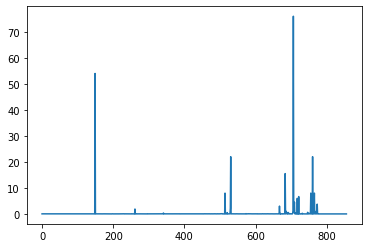

In [319]:
plt.plot(opioids_per_practice)

### Zscore of opioids proportion per practice

In order to know how these proportions compare to the overall opioid rate, we are going to substract the proportion of all prescriptions that are opioids from each practice's proportion

In [304]:
# Relative opioids_per_practice
################################
# Let's determine mu
# mean opioids prescription from all prescription: Overall rate
###############################################################
opioid_prescription_rate = sum(scripts['opioids'])/scripts.shape[0] # The mean prescription rate of opioid is 2.5% (population mean)

# Relative opioid prescription per practise: the difference between each practice's opioid prescription rate and the overall rate
relative_opioid_per_practice  = np.array(opioids_per_practice) - np.array(opioid_prescription_rate)
relative_opioid_per_practice = relative_opioid_per_practice.tolist()

In [334]:
# sigma of all the samples... 
sigma = np.std(opioids_per_practice)
standard_error_perpractice = [sigma/np.sqrt(practices_presc_counts[i]) for i in range(len(practices_presc_counts))]

In [335]:
# zscores computation
opioid_scores = [(relative_opioid_per_practice[i])/(standard_error_perpractice[i]) for i in range(len(practices_presc_counts))]

In [336]:
#Mapping between practice code and names
grouped = practices.groupby(['practice'])['name'].apply(list)
# Choosing the alphabetically first name
grouped = grouped.apply(lambda x: min(x))

In [337]:
# ordering the name of practices in the same order of the codes used throughout the analysis
name_practice_opioid_all = []
for practice in l_practices_all_opioids_first:
    name_practice_opioid_all.append(grouped.loc[practice])

In [338]:
anomalies_all = list(zip(name_practice_opioid_all,opioid_scores,practices_presc_counts))
anomalies_all.sort(key = lambda x: x[1],reverse=True)   # sort it by zscore
anomalies = anomalies_all[:100]
anomalies[:5]

[('WILLOW BANK SURGERY', 22.061085726802524, 1),
 ('THE LAKESIDE PRACTICE', 15.672857755947742, 1),
 ('DARWEN HEALTHCARE', 12.761779596681565, 4),
 ('ARDEN HEALTHCARE CENTRE', 6.380889798340783, 1),
 ('BARLBY SURGERY', 6.354710386756162, 2)]

### Task V: Script Growth

Another way to identify anomalies is by comparing current data to historical data. In the case of identifying sites of drug abuse, we might compare a practice's current rate of opioid prescription to their rate 5 or 10 years ago. Unless the nature of the practice has changed, the profile of drugs they prescribe should be relatively stable. We might also want to identify trends through time for business reasons, identifying drugs that are gaining market share. 

We'll load in beneficiary data from 6 months earlier, June 2016, and calculate the percent growth in prescription rate from June 2016 to January 2017 for each `bnf_name`. We'll return the 50 items with largest growth and the 50 items with the largest shrinkage (i.e. negative percent growth) as a list of tuples sorted by growth rate in descending order in the format `(script_name, growth_rate, raw_2016_count)`.Since many of the 50 fastest growing items have low counts of prescriptions in 2016. Filter out any items that were prescribed less than 50 times

In [31]:
# list of unique beneficiaries (bnf) from 2016
l_bnf_2016 = scripts16['bnf_name'].unique().tolist()
# list of unique beneficiaries (bnf) from 2017
l_bnf_2017= scripts['bnf_name'].unique().tolist()

# list of common bnf between 2016 and 2017
def list_intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))
common_bnf_names = list_intersection(l_bnf_2016,l_bnf_2017) #13540 common bnf between 2016 and 2017 

In [32]:
# Prescription rates refers to the count of prescriptions, not to the sum of items...
group_by_bnf_scripts16 = scripts16.groupby('bnf_name')['items'].count()
group_by_bnf_scripts = scripts.groupby('bnf_name')['items'].count()

In [33]:
# Saving prescription number in a corresponding order in a list for 2016 & 2017
l_bnf_presc_count_2016=[]
l_bnf_presc_count_2017=[]

for bnf in common_bnf_names:
    l_bnf_presc_count_2016.append(group_by_bnf_scripts16.loc[bnf])
    l_bnf_presc_count_2017.append(group_by_bnf_scripts.loc[bnf])    

In [48]:
growth =((np.array(l_bnf_presc_count_2017) - np.array(l_bnf_presc_count_2016))/np.array(l_bnf_presc_count_2016))*100

In [49]:
df = pd.DataFrame({'Name':common_bnf_names, '%growth': growth, 'baseline': l_bnf_presc_count_2016}) # 11587
# Filter out anything in 2016 prescribed less than 50
df_greaterthan50 =df[df['baseline']>= 50] 

In [50]:
common_bn_names_threshold = df_greaterthan50['Name'].tolist()
growth_threshold = df_greaterthan50['%growth'].tolist()
baseline_threshold = df_greaterthan50['baseline'].tolist()

In [51]:
# tuple
growth_tuple = list(zip(common_bn_names_threshold,growth_threshold,baseline_threshold))
growth_tuple.sort(key = lambda x: x[1],reverse=True) # ascending # sort on index 1 'growth_threshold'
#growth_copy.sort(key = lambda x: x[1],reverse=False) # descending
growth_final = growth_tuple[:50] + growth_tuple[-50:]
print('Top five bnf in +ve growth')
display(growth_final[:5])
print('Top five bnf in -ve growth')
display(growth_final[-5:])

Top five bnf in +ve growth


[('Butec_Transdermal Patch 5mcg/hr', 346.7741935483871, 62),
 ('Butec_Transdermal Patch 10mcg/hr', 300.0, 69),
 ('Fostair NEXThaler_Inh 200mcg/6mcg (120D)', 143.0232558139535, 86),
 ('Pneumococcal_Vac 0.5ml Vl (23 Valent)', 126.94300518134716, 193),
 ('Spiolto Respimat_Inha2.5/2.5mcg(60D)+Dev', 126.92307692307692, 52)]

Top five bnf in -ve growth


[('Hydroxyzine HCl_Oral Soln 10mg/5ml', -91.48936170212765, 94),
 ('Ovysmen_Tab', -92.53731343283582, 67),
 ('Climaval_Tab 1mg', -92.64705882352942, 136),
 ('Climesse_Tab', -94.20289855072464, 69),
 ('Polyalc_Eye Dps 1.4%', -99.63235294117648, 272)]

### Task VI: Rare Scripts

Something to explore: Do a practice's prescription costs originate from routine care or from reliance on rarely prescribed treatments? Commonplace treatments can carry lower costs than rare treatments because of efficiencies in large-scale production. While some specialist practices can't help but avoid prescribing rare medicines because there are no alternatives, some practices may be prescribing a unnecessary amount of brand-name products when generics are available. In this task, we are going identify practices whose costs disproportionately originate from rarely prescribed items.

In [ ]:
# Strategy: # Step I: Identify the 'bnf_codes' that are rare and find the probability p that a prescription having a particular
# code if the 'bnf_code' was randomly chosen from the unique options in the beneficiary data.
# Rare 'bnf_code' if it is prescribed at a rate less than 0.1 p

In [64]:
bnf_count_l = scripts.groupby('bnf_code')['items'].count().tolist() 
bnf_code_df = scripts.groupby('bnf_code')['items'].count().to_frame().reset_index()
bnf_pres_rate = np.array(bnf_count_l)/np.sum(bnf_count_l)

#Probability of choosing a unique bnf_code 1/total_num of uniques code
bnf_code_l = scripts['bnf_code'].unique().tolist()
prob_rand = 1/len(unique_bnf_num)# 1975

In [72]:
# Step II: for each practise, we are going to calculate the proportion of costs that originate from prescription of rare treatments 
# (i.e. rare 'bnf_code# 844 rare codes... there is a difference between script and a code , script is an individual entry
rare_codes = [bnf_code_l[i] for i in range(len(bnf_code_l)) if bnf_pres_rate[i] < 0.1*(prob_rand)] #844 rare codes

In [73]:
# Step III: adding a column 'rare' to the df
is_script_rare=[]
for script in scripts['bnf_code']:
    if script in rare_codes:
       is_script_rare. append(1)  
    else:
        is_script_rare.append(0)  
        
#adding rare columns to scripts
################################
scripts['rare']=is_script_rare 

In [74]:
# Step IV:
#########
# Rare Cost Proportion per Practice
###################################
# For each practice, calculate the proportion of costs that originate from the prescription of rare treatments
group_by_practice_scripts_cost = scripts.groupby('practice')['act_cost'].sum() # count of individual practice entries which are prescriptions Right 856 unique practices
group_by_practice_rare_scripts_cost  = scripts.groupby(['practice','rare'])['act_cost'].sum() # the length is 1621 if for each practice there is rare and no rare, you would
# get exactly double 856, but we got 1702.. meaning some practices have no rare... 

In [85]:
df = group_by_practice_rare_scripts_cost.to_frame().reset_index()
df.head()

,practice,rare,act_cost
0,A81005,0,64229.51
1,A81005,1,39611.31
2,A81007,0,70149.24
3,A81007,1,43333.25
4,A81011,0,101049.04


In [91]:
# calculate the proportion of rare costs out of practice costs
###############################################################
# List of unique postcodes sorted alphabetically
###############################################
# All practices:856
l_practices = scripts['practice'].unique().tolist()
# Pratices with rare: 848... 2 of them prescribe only rare.. 
practices_rare_l = [df.iloc[i]['practice'] for i in range(df.shape[0]) if df.iloc[i]['rare']==1] #848 practices prescribed rare.. 
# Costs of rare prescriptions in the practices
practices_rare_costs =[df.iloc[i]['act_cost'] for i in range(df.shape[0]) if df.iloc[i]['rare']==1]
# Interestingly there are 854 (total 856) that have 'no rare', meaning some practices only prescribed rare(2)

In [110]:
# Total costs of prescriptions of practices with rare prescriptions
costs_practices_l =[]
for practice in practices_rare_l:
    costs_practices_l.append(group_by_practice_scripts_cost.loc[practice])
rare_cost_prop = np.array(practices_rare_costs)/np.array(costs_practices_l)

In [114]:
#Zscore Computation
###################
#To compute mu : is across all practice
group_rare_prescrip = scripts.groupby('rare')['act_cost'].sum()
mean_rare_cost_prop = group_rare_prescrip.loc[1]/(group_rare_prescrip.loc[0] + group_rare_prescrip.loc[1]) 

In [115]:
# relative rare proportional costs
##################################
practices_relative_rare_costs_prop = rare_cost_prop - mean_rare_cost_prop
# variance
##########
standard_error_per_practice = np.sqrt(rare_cost_prop.var())
#Zscores
########
rare_scores = list(np.array(practices_relative_rare_costs_prop)/np.array(standard_error_per_practice))

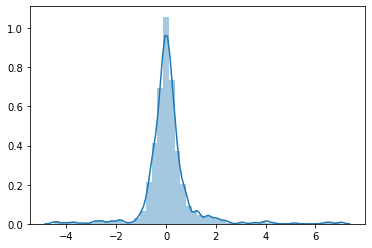

In [137]:
# Rare scores is normally distributed. Valid to perform zscore transformation
sns.distplot(rare_scores)

In [117]:
# Get practice names and postcodes from practices df, in Scripts, we have practice codes.
practices.head()

,practice,name,addr_1,addr_2,borough,village,post_code
0,A81002,QUEENS PARK MEDICAL CENTRE,QUEENS PARK MEDICAL CTR,FARRER STREET,STOCKTON ON TEES,CLEVELAND,TS18 2AW
1,A81003,VICTORIA MEDICAL PRACTICE,THE HEALTH CENTRE,VICTORIA ROAD,HARTLEPOOL,CLEVELAND,TS26 8DB
2,A81004,WOODLANDS ROAD SURGERY,6 WOODLANDS ROAD,NaN,MIDDLESBROUGH,CLEVELAND,TS1 3BE
3,A81005,SPRINGWOOD SURGERY,SPRINGWOOD SURGERY,RECTORY LANE,GUISBOROUGH,NaN,TS14 7DJ
4,A81006,TENNANT STREET MEDICAL PRACTICE,TENNANT ST MED PRACT,FARRER STREET,STOCKTON ON TEES,CLEVELAND,TS18 2AT


In [199]:
# Group practices by 'postal code' and by 'name' pick the first alphabetically postal code and pick the corresponding name
# Get a list of postcodes per practice
practices_group_by_pract = practices_sub.groupby('practice')['post_code'].apply(list) 
# Choosing the alphabetically first postal code
practices_group_by_pract = practices_group_by_pract.apply(lambda x: min(x))
# Turn into data frame for merger
practices_group_by_pract = practices_group_by_pract.to_frame().reset_index() 
# practices rare postcode
practices_rare_postcode_l = [practices_group_by_pract [practices_group_by_pract ['practice'] == practices_rare_l[i]]['post_code'].tolist() for i in range(len(practices_rare_l))]
practices_rare_postcode_l = sum(practices_rare_postcode_l,[])
#practices rare names
grouped = practices.groupby(['practice','post_code'])['name'].apply(list)
practices_rare_name_l = [grouped.loc[practices_rare_l[i]].loc[practices_rare_postcode_l[i]][0]  for i in range(len(practices_rare_l))]

In [201]:
rare_scripts = list(zip(practices_rare_postcode_l,practices_rare_name_l,rare_scores))
rare_scripts.sort(key = lambda x: x[2],reverse=True)   # sort it by zscore
rare_scripts = rare_scripts[:100]
rare_scripts[:3]

[('GL50 4DP', 'GPSI SKIN SURGERY SERVICE', 7.029900469138048),
 ('WD18 7QR', 'GYNAECOLOGY COMMUNITY SERVICE', 7.029900469138048),
 ('TS10 4NW', 'URGENT CARE CENTRE', 6.626667984080822)]

In [205]:
# Calculating p values ( statistically significant from mu: the average prescription rate of rare medicines across practices)
# Assumption data (rare-rate is normally distributed)
import scipy as sp
df = pd.DataFrame({'Name':practices_rare_name_l, 'Postal_Code':practices_rare_postcode_l, 'zscores': rare_scores})
significance = 0.05 # One tailed (greater than then mean rare prescription rate)
df['rare_rate_pvalues'] = 1 - sp.stats.norm.cdf(df['zscores'])
df['statistically_significant'] = (df.rare_rate_pvalues < significance).astype(int)

In [340]:
df.head()

,Name,Postal_Code,zscores,rare_rate_pvalues,statistically_significant
0,SPRINGWOOD SURGERY,TS14 7DJ,-0.105970,0.542197,0
1,BANKHOUSE SURGERY,TS24 7PW,-0.101495,0.540421,0
2,CHADWICK PRACTICE,TS24 7PW,-0.278676,0.609753,0
3,WESTBOURNE MEDICAL CENTRE,TS3 6AL,0.465854,0.320660,0
4,WOODBRIDGE PRACTICE,TS17 0EE,0.023269,0.490718,0
